Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, classification_report, roc_curve)

from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                              GradientBoostingClassifier, AdaBoostClassifier)
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline


Set a random seed and creat a synthetic dataset (of 20,000) with the features provided in the project description. 

In [3]:
np.random.seed(42)
n_records = 20000

#Gernerate data for each feature
data = {
    "Age": np.random.randint(18,65,size=n_records),
    "Gender": np.random.choice(["Male","Female"],size=n_records),
    "Marital_Status": np.random.choice(["Single","Married","Divorced"], size=n_records),
    "Education_Level": np.random.choice(["High School", "Bachelor","Master","PhD"], size=n_records),
    "Job_Role": np.random.choice(["Sales Executive", "Research Scientist", "Manager"], size=n_records),
    "Department": np.random.choice(["Sales","Marketing","HR","IT"], size=n_records),

    "Job_Satisfaction": np.random.randint(1,6, size=n_records),
    "Work_Life_Balance": np.random.randint(1,6,size=n_records),
    "Number_Of_Companies_Worked": np.random.randint(1,10, size=n_records),
    "Distance_From_Home": np.random.uniform(1,50, size=n_records).round(2),
    "Overtime": np.random.choice(["Yes","No"],size=n_records),
    "Job_Involvement":np.random.randint(1,6, size=n_records),

    "Salary": np.random.uniform(30000, 150000, size=n_records),
    "Hourly_Rate": np.random.uniform(15,100, size=n_records).round(2),
    "Stock_Option_Level": np.random.randint(0,5, size=n_records),
    "Bonuses": np.random.choice(["Yes","No"], size=n_records),

    "Years_At_Company": np.random.randint(0,40, size=n_records),
    "Training_Times_Last_Year": np.random.randint(0,10,size=n_records),
    "Job_Level": np.random.randint(1,6, size=n_records),
    "Employee_Recognition": np.random.choice(["Yes", "No"], size=n_records),

    "Performance_Rating": np.random.randint(1,6, size=n_records),
    "Absenteeism": np.random.randint(0,20, size=n_records),
}

In [4]:
#Creat the DataFram
df = pd.DataFrame(data)

#Generate the target variables with calss imbalance of 10% attrition rate
df["Attrition"] = np.where(np.random.rand(n_records) < 0.1,1,0)

#Display the first few rows
rows, cols = df.shape
print(f"Number of Rows: {rows}")
df.head()

Number of Rows: 20000


,Age,Gender,Marital_Status,Education_Level,Job_Role,Department,Job_Satisfaction,Work_Life_Balance,Number_Of_Companies_Worked,Distance_From_Home,...,Hourly_Rate,Stock_Option_Level,Bonuses,Years_At_Company,Training_Times_Last_Year,Job_Level,Employee_Recognition,Performance_Rating,Absenteeism,Attrition
0,56,Male,Married,Master,Research Scientist,IT,2,3,3,24.32,...,37.95,4,Yes,31,1,2,No,3,12,0
1,46,Male,Divorced,Master,Manager,HR,4,2,1,26.74,...,52.35,2,Yes,28,4,2,Yes,1,17,0
2,32,Male,Married,Master,Manager,IT,2,2,8,22.91,...,37.21,1,Yes,25,1,1,Yes,3,2,0
3,60,Female,Divorced,Master,Sales Executive,Sales,4,1,7,39.29,...,93.75,0,No,28,2,2,Yes,5,9,0
4,25,Male,Divorced,Bachelor,Sales Executive,HR,1,4,3,31.32,...,27.63,3,Yes,9,3,3,No,1,14,0


In [5]:
# Handle missing values
print(df.isnull().sum())

# Fill numerical columns with median
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

#Fill categorical columns with mode
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

Age                           0
Gender                        0
Marital_Status                0
Education_Level               0
Job_Role                      0
Department                    0
Job_Satisfaction              0
Work_Life_Balance             0
Number_Of_Companies_Worked    0
Distance_From_Home            0
Overtime                      0
Job_Involvement               0
Salary                        0
Hourly_Rate                   0
Stock_Option_Level            0
Bonuses                       0
Years_At_Company              0
Training_Times_Last_Year      0
Job_Level                     0
Employee_Recognition          0
Performance_Rating            0
Absenteeism                   0
Attrition                     0
dtype: int64


In [6]:
#one hot encode all categorical columns
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [7]:
#Identify numerical columns (excluding the target variable)
num_cols = [col for col in df_encoded.columns if df_encoded[col].dtype in ["int64", "float64"] and col != "Attrition"]

scaler = StandardScaler()
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

Creat Models and compare the performance using three different models.

In [8]:
# Seperate features and target
X = df_encoded.drop("Attrition", axis=1)
y = df_encoded["Attrition"]

#Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate the ratio of negative to positive calsses in y_train
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

#Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight={0:1, 1:10}),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric = "logloss", random_state=42, scale_pos_weight=scale_pos_weight)
}

# Function to evaluate and print model performance
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

    print(f"----- {name} -----")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    if y_pred_prob is not None:
        print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
    print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))
    print("\n")


In [ ]:
# Resample training data using SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1.0)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE training set class distribution:", Counter(y_train_res))

# Define a parameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.5],
    'scale_pos_weight': [scale_pos_weight, scale_pos_weight * 2]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

grid_search = GridSearchCV(xgb, param_grid, scoring='f1', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_res, y_train_res)

print("Best parameters for XGBoost:", grid_search.best_params_)

# Replace the XGBoost model in our models dictionary with the tuned estimator
models["XGBoost"] = grid_search.best_estimator_

# Now train your models with the resampled data
for name, model in models.items():
    print(f"Training {name} with SMOTE resampled data...")
    model.fit(X_train_res, y_train_res)
    evaluate_model(name, model, X_test, y_test)


After SMOTE training set class distribution: Counter({0: 14310, 1: 14310})
Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


In [ ]:
#Train each model and evaluate
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    evaluate_model(name, model, X_test, y_test)

Training Random Forest...
----- Random Forest -----
Accuracy: 0.8955
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC-AUC: 0.492635292357588

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94      3582
           1       0.00      0.00      0.00       418

    accuracy                           0.90      4000
   macro avg       0.45      0.50      0.47      4000
weighted avg       0.80      0.90      0.85      4000



Training Gradient Boosting...


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


----- Gradient Boosting -----
Accuracy: 0.8955
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC-AUC: 0.5315840232528939

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.94      3582
           1       0.00      0.00      0.00       418

    accuracy                           0.90      4000
   macro avg       0.45      0.50      0.47      4000
weighted avg       0.80      0.90      0.85      4000



Training XGBoost...


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:38:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


----- XGBoost -----
Accuracy: 0.8705
Precision: 0.08333333333333333
Recall: 0.023923444976076555
F1 Score: 0.03717472118959108
ROC-AUC: 0.49795695649967003

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93      3582
           1       0.08      0.02      0.04       418

    accuracy                           0.87      4000
   macro avg       0.49      0.50      0.48      4000
weighted avg       0.81      0.87      0.84      4000





Final Prediction Code

In [ ]:
expected_cols = X.columns

def prepare_sample(sample_dict, expected_cols):
    df_sample = pd.DataFrame([sample_dict])
    for col in expected_cols:
        if col not in df_sample.columns:
            df_sample[col] = np.nan
    df_sample = df_sample[expected_cols]
    return df_sample

def predict_employee_attrition(employee_features, model, scaler, expected_cols, cat_cols, num_cols):
    df_sample = pd.DataFrame([employee_features])
    df_sample_encoded = pd.get_dummies(df_sample, columns=cat_cols, drop_first=True)
    df_sample_encoded = df_sample_encoded.reindex(columns=expected_cols, fill_value=0)
    df_sample_encoded[num_cols] = scaler.transform(df_sample_encoded[num_cols])
    prediction = model.predict(df_sample_encoded)
    prediction_prob = model.predict_proba(df_sample_encoded)[:, 1]
    return int(prediction[0]), float(prediction_prob[0])

# Pull a random employee from the original data and predict
random_index = np.random.choice(df.index)
random_employee = df.loc[random_index].to_dict()
actual_attrition = random_employee.pop("Attrition")
print("Random Employee Data:")
print(random_employee)
print("Actual Attrition:", "Leave" if actual_attrition == 1 else "Stay")

prediction, probability = predict_employee_attrition(random_employee, models["XGBoost"], scaler, X.columns, cat_cols, num_cols)
result = "Leave" if prediction == 1 else "Stay"
print("\nPrediction for random employee:", result)
print("Probability of leaving: {:.2f}".format(probability))
confidence = probability if probability >= 0.5 else 1 - probability
print("Model Confidence: {:.2f}%".format(confidence * 100))
print("Prediction is", "correct." if prediction == actual_attrition else "incorrect.")



NameError: name 'X' is not defined

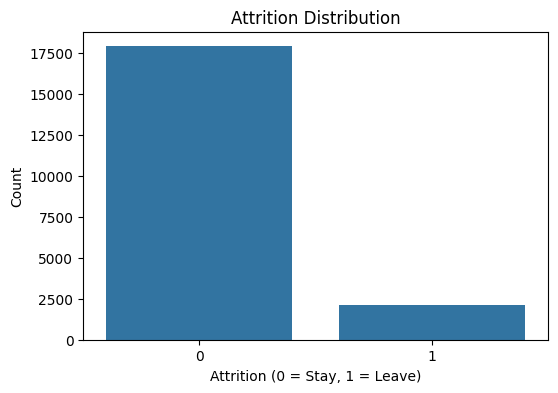

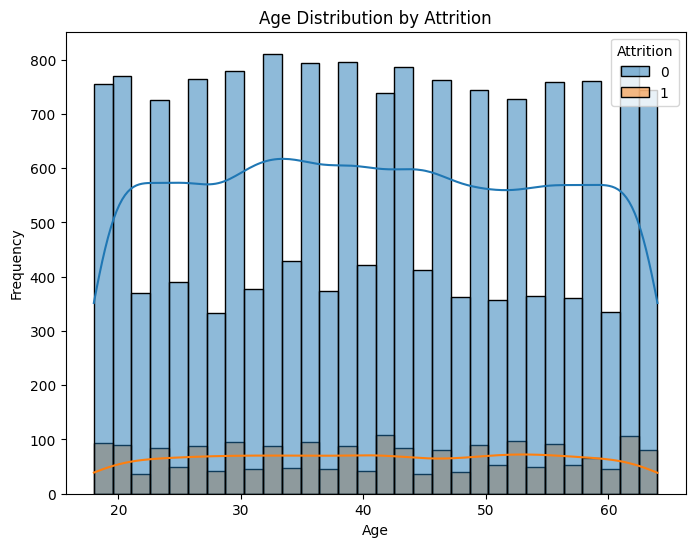

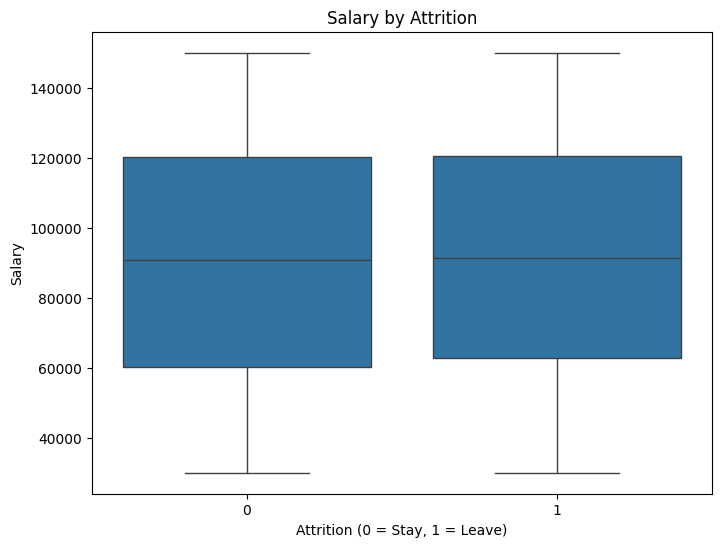

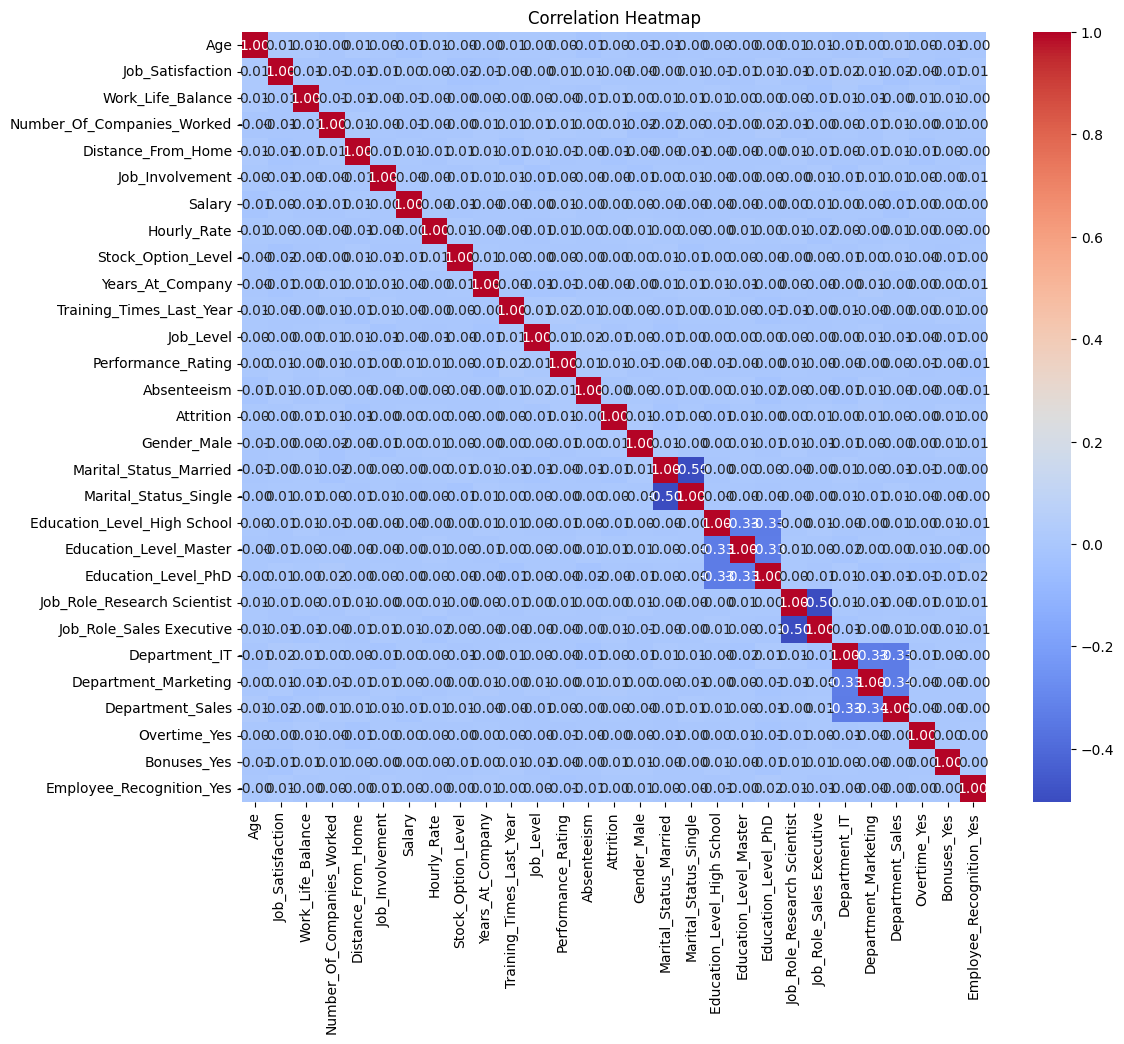

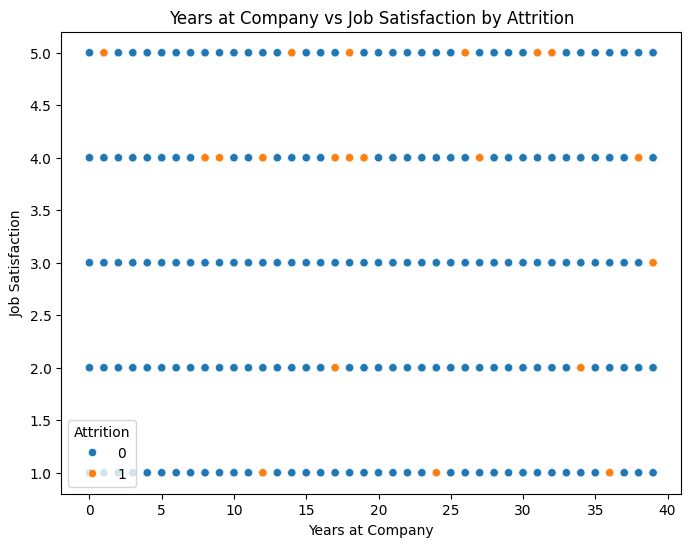

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization 1: Attrition Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="Attrition", data=df)
plt.title("Attrition Distribution")
plt.xlabel("Attrition (0 = Stay, 1 = Leave)")
plt.ylabel("Count")
plt.show()

# Visualization 2: Age Distribution by Attrition
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="Age", hue="Attrition", bins=30, kde=True)
plt.title("Age Distribution by Attrition")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# Visualization 3: Salary Distribution by Attrition (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x="Attrition", y="Salary", data=df)
plt.title("Salary by Attrition")
plt.xlabel("Attrition (0 = Stay, 1 = Leave)")
plt.ylabel("Salary")
plt.show()

# Visualization 4: Correlation Heatmap of Encoded Features
plt.figure(figsize=(12, 10))
corr_matrix = df_encoded.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Visualization 5: Scatter Plot of Years at Company vs Job Satisfaction by Attrition
plt.figure(figsize=(8, 6))
sns.scatterplot(x="Years_At_Company", y="Job_Satisfaction", hue="Attrition", data=df)
plt.title("Years at Company vs Job Satisfaction by Attrition")
plt.xlabel("Years at Company")
plt.ylabel("Job Satisfaction")
plt.show()
